In [17]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from keras import layers
from keras import activations

import matplotlib.pyplot as plt

classes_no = 10


def one_hot_encoding(labels):
    one_hot = tf.one_hot(labels, classes_no, dtype=tf.float32)
    return tf.reshape(one_hot, (labels.shape[0], classes_no))


def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    ax = plt.gca()
    ax.set_ylim([0.0, 1.0])
    plt.show()


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    ax = plt.gca()
    ax.set_ylim([0.0, 2.5])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def retrieve_history(name):
    np.load(f'history/{name}.npy', allow_pickle='TRUE').item()


def save_history(name, history):
    np.save(f'history/{name}.npy', history.history)


(x_train, y_raw_train), (x_test, y_raw_test) = tf.keras.datasets.cifar10.load_data()

train_size = 50000
test_size = 10000
epochs = 150
# train_size = 1000
# test_size = 10
# epochs = 10

x_train, y_train = x_train[:train_size], one_hot_encoding(y_raw_train[:train_size])
x_test, y_test = x_test[:test_size], one_hot_encoding(y_raw_test[:test_size])


In [2]:
def block(filters_no, dropout_rate, filter_size=(3, 3), pool_size=(8, 8), gap=False):
    layer_1 = layers.Conv2D(
        filters_no, filter_size,
        strides=1,
        padding='same',
        activation=activations.relu
    )
    layer_1_post = layers.BatchNormalization()
    layer_2 = layers.Conv2D(
        filters_no, filter_size,
        strides=1,
        padding='same',
        activation=activations.relu
    )

    if not gap:
        layer_3 = layers.MaxPooling2D(
            pool_size=pool_size,
            strides=pool_size,
            padding='same')
    else:
        layer_3 = layers.GlobalAvgPool2D()

    dropout_layer = layers.Dropout(dropout_rate)

    return [layer_1, layer_1_post, layer_2, layer_3, dropout_layer]

model = keras.Sequential([
    layers.Rescaling(scale=1./255.),
    *block(20, .1),
    *block(40, .2),
    *block(80, .3),
    *block(160, .4, gap=True),
    layers.Flatten(),
    layers.Dense(10, activation=activations.softmax)
])


model.build([None, None, None, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 20)    560       
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 20)    80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 20)    3620      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 20)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 20)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 40)    7

In [3]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(loss=loss_fn,optimizer=optimizer, metrics=[keras.metrics.CategoricalAccuracy()])
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

save_history('part_4', history)
model.save('models/model')

Epoch 1/150
782/782 [==============================] - 43s 15ms/step - loss: 2.0323 - categorical_accuracy: 0.2125 - val_loss: 1.9074 - val_categorical_accuracy: 0.2727
Epoch 2/150
782/782 [==============================] - 11s 14ms/step - loss: 1.7787 - categorical_accuracy: 0.3142 - val_loss: 1.5613 - val_categorical_accuracy: 0.4239
Epoch 3/150
782/782 [==============================] - 10s 13ms/step - loss: 1.6685 - categorical_accuracy: 0.3673 - val_loss: 1.5088 - val_categorical_accuracy: 0.4497
Epoch 4/150
782/782 [==============================] - 11s 14ms/step - loss: 1.5677 - categorical_accuracy: 0.4153 - val_loss: 1.5062 - val_categorical_accuracy: 0.4377
Epoch 5/150
782/782 [==============================] - 11s 14ms/step - loss: 1.4896 - categorical_accuracy: 0.4499 - val_loss: 1.3718 - val_categorical_accuracy: 0.4899
Epoch 6/150
782/782 [==============================] - 11s 14ms/step - loss: 1.4162 - categorical_accuracy: 0.4827 - val_loss: 1.3963 - val_categorical_acc

In [4]:
!zip -r /content/file.zip /content/models /content/imgs /content/history

  adding: content/models/ (stored 0%)
  adding: content/models/model/ (stored 0%)
  adding: content/models/model/saved_model.pb (deflated 89%)
  adding: content/models/model/keras_metadata.pb (deflated 94%)
  adding: content/models/model/variables/ (stored 0%)
  adding: content/models/model/variables/variables.data-00000-of-00001 (deflated 46%)
  adding: content/models/model/variables/variables.index (deflated 73%)
  adding: content/models/model/assets/ (stored 0%)
  adding: content/imgs/ (stored 0%)
  adding: content/imgs/horse_scaled.jpeg (deflated 7%)
  adding: content/history/ (stored 0%)
  adding: content/history/part_4.npy (deflated 54%)


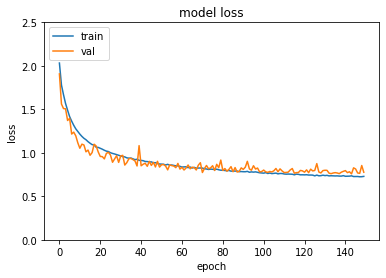

In [5]:
plot_loss(history)

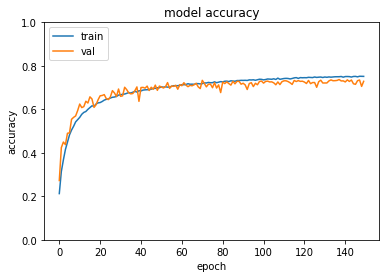

In [6]:
plot_accuracy(history)


In [21]:
model = keras.models.load_model('models/model')

In [22]:
from tensorflow import convert_to_tensor

from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array

def load_image(image_path):
    image = load_img(image_path)
    numpy_data = img_to_array(image)


    return convert_to_tensor(numpy_data) / 255.0

test_img = load_image('imgs/plane_scaled.jpeg')

q = model.predict(np.array([test_img]))[0]
tf.argmax(q)

[7.8739232e-01 5.7246600e-04 7.2566763e-02 1.5912121e-02 3.1527136e-02
 1.7879192e-03 1.1156389e-02 1.3249980e-03 7.6183602e-02 1.5762607e-03]


<tf.Tensor: shape=(), dtype=int64, numpy=0>